In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random

In [2]:
import networkx as nx

In [3]:
random.seed(42)

In [4]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [5]:
dataset.columns=['Index','Source','Target']

In [6]:
# check if index columns has unique values
print(len(dataset.Index))
print(len(set(dataset.Index)))

483094
483094


In [7]:
dataset.set_index('Index' , inplace = True)
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


#### Associate single category to each node

In [8]:
# all nodes in and out
unique_nodes = set(set(dataset.Source).union(set(dataset.Target)))
n_nodes = len(unique_nodes)
n_edges = len(dataset)

In [9]:
n_nodes

98343

In [10]:
category_file = 'wiki-topcats-categories.txt'

In [11]:
categories = {v: [] for v in unique_nodes}
lost = []
with open(category_file) as file:
    for i in range(17364):
        line = file.readline()
        category = line.split(';')[0].split(':')[-1]
        nodes = line.split(';')[1].split(' ')[1:-2]
        for node in nodes:
            try:
                categories[int(node)].append(category)
            except:
                lost.append(int(node))

In [12]:
categories_filtered = {}
for n in categories.keys():
    try:
        rand_category = random.choice(categories[n])
        categories_filtered[n] = rand_category
    except:
        categories_filtered[n] = None

## RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

- Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

Useful links:
- https://brilliant.org/wiki/ford-fulkerson-algorithm/
- https://www.hackerearth.com/practice/algorithms/graphs/maximum-flow/tutorial/
- https://en.wikipedia.org/wiki/Cut_(graph_theory)
- https://web.stanford.edu/class/archive/cs/cs161/cs161.1172/CS161Lecture16.pdf
- https://www.youtube.com/watch?v=oDqjPvD54Ss

In [13]:
categories_filtered[1049773]

'16th-century_English_people'

Using networkx

In [14]:
G = nx.Graph()

In [15]:
for row in dataset.iterrows():
    G.add_edge(row[1][0], row[1][1], capacity=1)

In [17]:
H = G.to_undirected()

In [18]:
def add_categories(my_category, G):
    for i in my_category.keys():
        G.nodes[i]['category']=my_category[i]
    return G

In [19]:
add_categories(categories_filtered, H)

In [20]:
def add_categories(my_category, G):
    for i in my_category.keys():
        G.nodes[i]['category']=my_category[i]
    return G

add_categories(categories_filtered, H)

In [21]:
def get_subgraph(G, c1, c2):
    new_graph = G.copy()
    for i in list(new_graph.nodes):
        if new_graph.nodes[i]['category']!=c1 and new_graph.nodes[i]['category']!=c2:
            new_graph.remove_node(i)
    return new_graph

In [22]:
sub_category_graph = get_subgraph(H, 'American_television_actors', 'Films_based_on_novels')
sub_category_graph.number_of_edges()

721

## Functions

In [23]:
#simple BFS - O(V+E)
def find_all_connected_nodes(g, starter_node):
    visited = []
    queue = []
    
    visited.append(starter_node)
    queue.append(starter_node)
    
    nodes = []
    
    while queue:
        s = queue.pop(0)
        nodes.append(s)
        
        for neighbour in g[s]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)
                
    return nodes

In [24]:
class BreakException(Exception):
    pass

def path_not_found():
    raise BreakException()

def shortest_path(g, u, v):
    
    '''
    It is a "BFS" method and return the first path with minimum distance from u to v 
    
    '''
    if u == v:
        return 'same node'  
    
    visited = [] #list of visited nodes
    queue = [[u]] #queue structure
    
    visited.append(u) #add u to visited list
    
    nodes = [] #list of nodes --> path
    
    #calculate all paths with n distance
    #when i have v in nodes return nodes
    while queue:
        s = queue.pop(0)

        for neighbour in g[s[-1]]:
            if neighbour not in visited:
                nodes = list(s)
                nodes.append(neighbour)
                queue.append(nodes)
                visited.append(neighbour)
                
                if neighbour == v:
                    return nodes
                
    return path_not_found()

In [25]:
def find_paths(g, u, v):
    
    '''
    
    '''
    
    graph = g.copy()
    
    paths = []
    
    while True:
        try:
            path = shortest_path(graph, u, v)
        except BreakException:
            break

        paths.append(path)
        index = random.choice(range(1, len(path)))
        graph.remove_edge(path[index-1], path[index])    
                
    return paths   

In [26]:
def simple_min_cut(g, u, v, starter):
    
    '''
    1. Chose one path from u to v --> starter
    2. Remove all edges of the path
    3. Reapet 1 and 2 until there's no path
    4. return the number of path found
    '''

    print(f'random_path: {starter}')
    index=1
    
    my_g = g.copy()
    for j in range(1, len(starter)):
        my_g.remove_edge(starter[j-1], starter[j])
        #print(f'{index} removed: {starter[j-1]}, {starter[j]}')

    while True:
        try:
            nodes_list = shortest_path(my_g, u, v)
            print('----')
        except BreakException:
            print(f'Another path not found! MinCut: {index}')
            break

        index+=1
        for j in range(1, len(nodes_list)):
            my_g.remove_edge(nodes_list[j-1], nodes_list[j])
            print(f'{index} removed: {nodes_list[j-1]}, {nodes_list[j]}')

    return index

In [28]:
def augmented_min_cut(g, u, v):
    
    '''
    1) if u and v are the same node -> return 'same node'
    2) if deg of u or v is 1 -> return 1
    3) paths = call find_paths to calculate different paths
    4) if paths have just one path -> return 1
    5) use simple_min_cut for each path in paths
    6) return the max of the min cuts
    '''
    '''
    if u == v:
        return 'Same node'
    
    if g.degree(u) == 1 or g.degree(v) == 1:
        return 1
    '''
    paths = find_paths(g, u, v)
    print(paths)
    lenght = len(paths)
    if lenght == 1:
        return 1
    results = []
    
    for i in range(lenght):
        index = simple_min_cut(g, u, v, paths[i]) 
        results.append(index)
    
    print(results)
    return max(results)

In [29]:
subgraph = sub_category_graph.copy()

In [31]:
u=1061503
v=1164980

Testing shortest_path

In [32]:
shortest_path(subgraph, u, v)

[1061503, 1163479, 1163088, 1164985, 1164980]

In [33]:
nx.shortest_path(subgraph, u, v)

[1061503, 1163479, 1163088, 1164985, 1164980]

Testing min_cut

In [149]:
augmented_min_cut(subgraph, u, v)

[[1061503, 1163479, 1163088, 1164985, 1164980], [1061503, 1165303, 1165344, 358008, 1164985, 1164980], [1061503, 1163479, 1163416, 1163623, 358008, 1164985, 1164980], [1061503, 1163664, 1163731, 1163736, 1165344, 358008, 1164985, 1164980], [1061503, 1165146, 1165286, 1161081, 1165344, 358008, 1164985, 1164980], [1061503, 1165374, 1165662, 1165303, 1165344, 358008, 1164985, 1164980], [1061503, 1165374, 1165324, 1165303, 1165344, 358008, 1164985, 1164980], [1061503, 1165754, 1165217, 1165324, 1165303, 1165344, 358008, 1164985, 1164980], [1061503, 1165203, 1165155, 1165469, 1165225, 1165303, 1165344, 358008, 1164985, 1164980], [1061503, 1165737, 1163688, 1163667, 1165321, 1165324, 1165303, 1165344, 358008, 1164985, 1164980], [1061503, 1163674, 1163615, 1163761, 1065580, 1165662, 1165303, 1165344, 358008, 1164985, 1164980]]
random_path: [1061503, 1163479, 1163088, 1164985, 1164980]
Another path not found! MinCut: 1
random_path: [1061503, 1165303, 1165344, 358008, 1164985, 1164980]
Another 

1

In [34]:
cut_value, partition = nx.minimum_cut(subgraph, u, v)
cut_value

1

### Visualization

In [54]:
a = (find_all_connected_nodes(subgraph, u))

In [55]:
reduced_graph = subgraph.copy()
for i in list(subgraph.nodes):
    if i in a:
        pass
    else:
        reduced_graph.remove_node(i)

In [58]:
node_sizes = [10*len(reduced_graph.edges(n)) for n in reduced_graph.nodes()]
#networkx.draw_spring(g, node_size=(node_sizes))
#nx.draw_kamada_kawai(subgraph, node_size=(node_sizes), with_labels=True)#785539
color_map = []
for node in reduced_graph:
    if node == u or node == v:
        color_map.append('red')
    else: 
        color_map.append('blue')

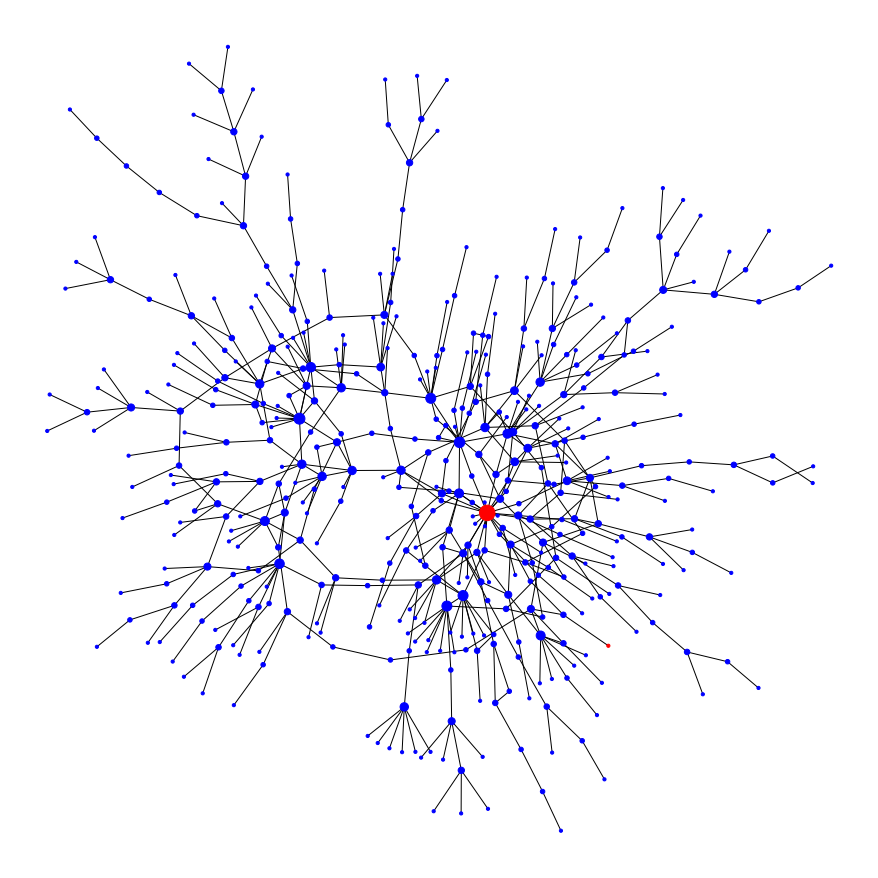

In [62]:
plt.figure(1, figsize=(12,12))
nx.draw_kamada_kawai(reduced_graph, node_size=(node_sizes), node_color=color_map) 
#--> with_labels=True, font_size = 5
plt.show()